In [34]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
import sys
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, extarct, extarct_multiple, createSel

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Preliminary"

donotdelete = []

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [5]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Load data

In [6]:
f = '../data/cmsRD/ParkingBPH1/Run2018A-05May2019-v1_RDntuplizer_B2JpsiKst_191001_CAND.root'
t = ur.open(f)['outA']['Tevts']
# print tMC.keys(), '\n\n'
branches = t.keys()
for b in np.sort(branches):
#     pass
    print b

B_E
B_P
B_eta
B_phi
B_pt
B_pz
Jpsi_E
Jpsi_P
Jpsi_eta
Jpsi_phi
Jpsi_pt
Jpsi_pz
K_E
K_N_valid_hits
K_P
K_eta
K_norm_chi2
K_phi
K_pt
K_pz
Kst_E
Kst_P
Kst_eta
Kst_phi
Kst_pt
Kst_pz
LumiBlock
Run
chi2_B
chi2_Jpsi
chi2_JpsiKst
chi2_Kpi
chi2_Kst
chi2_mumu
cos_B_PV
cos_Jpsi_vtxMu
cos_Kst_PV
d_vtxB_PV
d_vtxJpsi_PV
d_vtxKst_PV
eventNumber
mass_JpsiKst
mass_Kpi
mass_mumu
mum_E
mum_P
mum_dxy
mum_eta
mum_isTrg
mum_phi
mum_pt
mum_pz
mum_sigdxy
mup_E
mup_P
mup_dxy
mup_eta
mup_isTrg
mup_phi
mup_pt
mup_pz
mup_sigdxy
n_B
n_Jpsi
n_K
n_Kst
n_pi
pi_E
pi_N_valid_hits
pi_P
pi_eta
pi_norm_chi2
pi_phi
pi_pt
pi_pz
sigd_K_PV
sigd_pi_PV
sigd_vtxB_PV
sigd_vtxJpsi_PV
sigd_vtxKst_PV
trgMu_charge
trgMu_dxy
trgMu_dz
trgMu_eta
trgMu_phi
trgMu_pt
trgMu_sigdxy


In [7]:
d = extarct(t, branches=branches)
print 'Number of events:', d['n_B'].shape[0]
print 'Number of candidates:', d['mass_JpsiKst'].shape[0]

Number of events: 11793
Number of candidates: 12784


# Cuts declaration

In [13]:
inj_chi2_pval_cut = 0.95
for b in branches:
    if b.startswith('chi2_'):
        max_chi2 = np.max(d[b])
        print 'Vertex', b[5:] 
        print 'Max chi2:', max_chi2
        
        

sps.chi2.cdf(max_chi2, 1)

Vertex B
Max chi2: 4132.6885
Vertex Jpsi
Max chi2: 2073.989
Vertex JpsiKst
Max chi2: 3.840481
Vertex Kpi
Max chi2: 3.8412197
Vertex Kst
Max chi2: 2018.7179
Vertex mumu
Max chi2: 3.8379116


0.9498941056477461

# Muon system

In [ ]:
h = create_TH1D(dMC['mass_Kpi'], 
                axis_title=['Mass (K#pi) [GeV]', 'Candidates'],
                binning=np.linspace(m_D0-0.08, m_D0+0.08, 100)
               )

# Hadron system

# Full analysis

In [56]:
cut = {}

####----- Trigger-like cuts -----#
cut['mum_pt'] = ['>', 3.5]
cut['mup_pt'] = ['>', 3.5]
cut['Jpsi_pt'] = ['>', 6.9]
# Missing: sigdxy_vtxJpsi_PV > 3
cut['chi2_mumu'] = ['<', sps.chi2.ppf(0.90, 1)]
cut['mum_eta'] = ['>', -2.2]
cut['mup_eta'] = ['>', -2.2]
cut['_mum_eta'] = ['<', 2.2]
cut['_mup_eta'] = ['<', 2.2]
# Missing: dca_mumu < 0.5 cm
cut['cos_Jpsi_vtxMu'] = ['>', 0.9]

####----- Muon systems cuts -----#
cut['mum_dxy'] = ['<', 3]
cut['mup_dxy'] = ['<', 3]

####----- Hadron systems cuts -----#
cut['K_pt'] = ['>', 0.8]
cut['pi_pt'] = ['>', 0.8]
cut['sigd_K_PV'] = ['>', 2]
cut['sigd_pi_PV'] = ['>', 2]

In [57]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

def createSel(d, cut):
    k_ref = cut.keys()[0]
    if k_ref[0] == '_': 
            k_ref = k_ref[1:]
    sel = np.ones_like(d[k_ref], dtype=bool)
    for k, v in cut.iteritems():
        if k[0] == '_': 
            k = k[1:]
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
        
    eff = np.sum(sel)/float(sel.shape[0])
    return sel, eff

In [58]:
sel_prelim, eff = createSel(d, cut)
print eff

0.22449937421777222


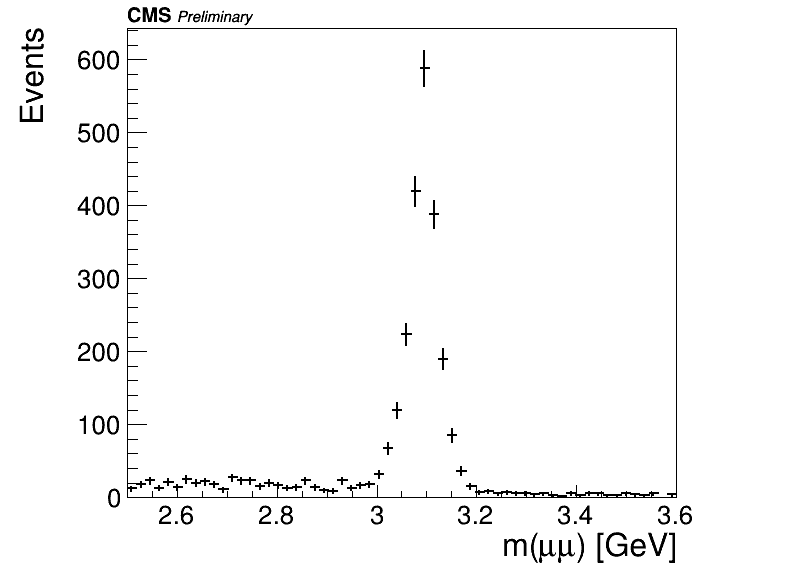

In [59]:
h = create_TH1D(d['mass_mumu'][sel_prelim], 
                title='',
                axis_title=['m(#mu#mu) [GeV]', 'Events'],
                binning=[60, 2.5, 3.6]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

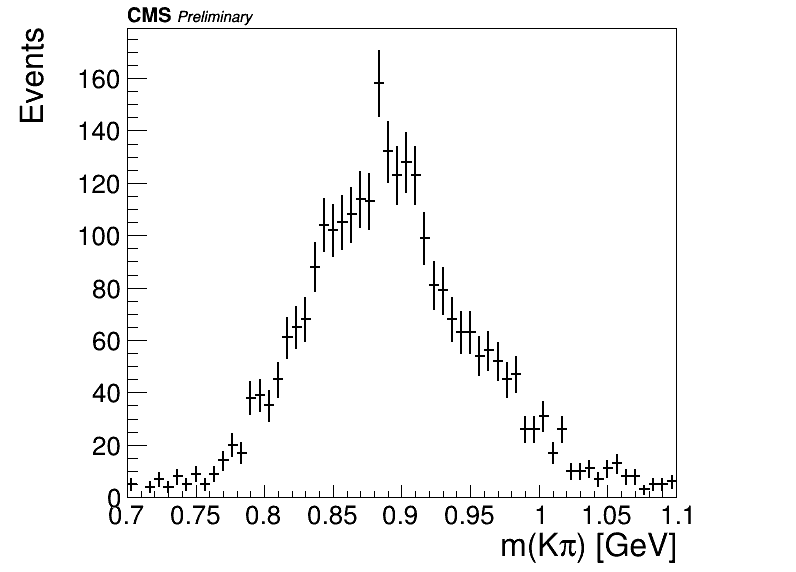

In [60]:
h = create_TH1D(d['mass_Kpi'][sel_prelim], 
                title='',
                axis_title=['m(K#pi) [GeV]', 'Events'],
                binning=[60, 0.7, 1.1]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()

In [61]:
cut['mass_mumu'] = ['<',  3.2]
cut['_mass_mumu'] = ['>',  3.0]
cut['mass_Kpi'] = ['<',  0.96]
cut['_mass_Kpi'] = ['>',  0.8]

In [62]:
sel_an, eff = createSel(d, cut)
print eff

0.13266583229036297


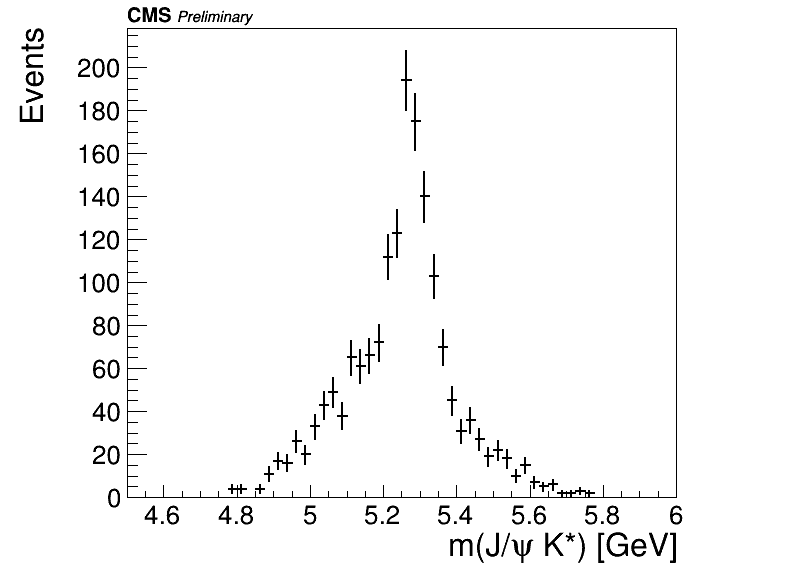

In [64]:
h = create_TH1D(d['mass_JpsiKst'][sel_an], 
                title='',
                axis_title=['m(J/#psi K*) [GeV]', 'Events'],
                binning=[60,4.5, 6]
               )
h.Sumw2()
                                   
c = drawOnCMSCanvas(CMS_lumi, [h], 'same')
c.SetRightMargin(0.15)
c.Draw()